In [ ]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from tqdm.autonotebook import tqdm
import IPython.display as ipd
from IPython.display import Audio
import torchvision.transforms as T
import warnings
from classification_model import Net
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
data_path = './data/emotifymusic'

In [ ]:
labels = pd.read_csv('./data/emotifymusic/emotion_labels.csv', sep=",", header=0)

In [ ]:
emotions = {'1': 'Amazement', '2':'Solemnity', '3':'Tenderness', '4':'Nostalgia', '5':'Calmness'}
            

In [ ]:
labels

,track id,genre,mood
0,1,classical,4
1,2,classical,3
2,3,classical,4
3,4,classical,4
4,5,classical,4
...,...,...,...
395,396,pop,4
396,397,pop,4
397,398,pop,4
398,399,pop,4


In [ ]:
cmap = plt.get_cmap('inferno')

In [ ]:
plt.figure(figsize=(8,8))
genres = 'classical rock electronic pop'.split()
count = -100
emotions_values = emotions.values()
for emotion in emotions_values:
  pathlib.Path(f'./data/emotifymusic/emotion_img_data/{emotion}').mkdir(parents=True, exist_ok=True)
for g in genres:
  count+=100
  for filename in os.listdir(f'{data_path}/{g}'):
    songname = f'{data_path}/{g}/{filename}'
    if '.ipynb' not in songname:
      y, sr = librosa.load(songname, mono=True, duration=30)
      plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
      plt.axis('off');
      filename = filename.replace(".mp3", "")
      mood = labels[labels[' genre' ]==g][labels['track id' ]== count + int(filename)][' mood'].values[0]
      
      plt.savefig(f'./data/emotifymusic/emotion_img_data/{emotions[str(mood)]}/{g}_{filename}.png')
      plt.clf()

<Figure size 576x576 with 0 Axes>

In [ ]:
img_path = './data/emotifymusic/emotion_img_data/'

In [ ]:
batch_size = 8
image_size = 224

In [ ]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [ ]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [ ]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

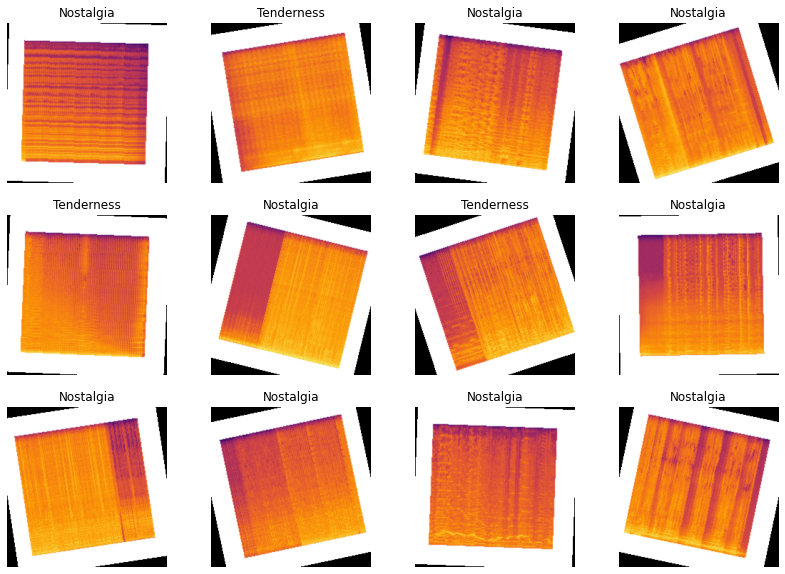

In [ ]:
class_plot(train_data)

In [ ]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(360, 40)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([8, 3, 224, 224])


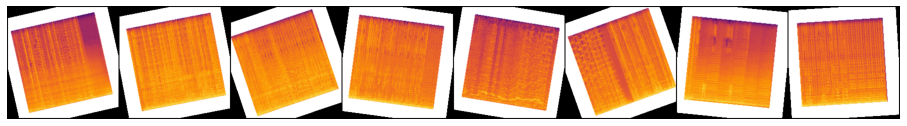

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
Net()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model = to_device(Net(), device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history = [evaluate(model, val_dl)]

In [ ]:
model.freeze()

In [ ]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.0010, val_score: 0.2292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.6953, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.6855, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.8143, val_score: 0.4375


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.7522, val_score: 0.7500
CPU times: user 23.5 s, sys: 4.79 s, total: 28.3 s
Wall time: 50.8 s


In [ ]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.7827, val_score: 0.5000


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.7135, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.7994, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.8688, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.7971, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.8088, val_score: 0.5000


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.6488, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.9170, val_score: 0.3958


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.7231, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9], val_loss: 0.7586, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.8055, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.7496, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.8174, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13], val_loss: 0.7783, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14], val_loss: 0.7875, val_score: 0.6250
CPU times: user 1min 10s, sys: 13.8 s, total: 1min 24s
Wall time: 2min 31s


In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.7657, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.7999, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.8034, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.7829, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.8693, val_score: 0.2917


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.7883, val_score: 0.5208


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.8090, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.7963, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.8515, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9], val_loss: 0.6867, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.7446, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.8075, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.0020, val_score: 0.3333


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13], val_loss: 0.6782, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14], val_loss: 0.7786, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [15], val_loss: 0.6817, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [16], val_loss: 0.7537, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [17], val_loss: 0.7114, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [18], val_loss: 0.8495, val_score: 0.3125


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [19], val_loss: 0.8018, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [20], val_loss: 0.8721, val_score: 0.2917


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [21], val_loss: 0.8652, val_score: 0.2500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [22], val_loss: 0.8951, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [23], val_loss: 0.9229, val_score: 0.4167


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [24], val_loss: 0.8202, val_score: 0.4583


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [25], val_loss: 0.8252, val_score: 0.3958


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [26], val_loss: 0.7773, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [27], val_loss: 0.6879, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [28], val_loss: 0.7691, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [29], val_loss: 0.7652, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [30], val_loss: 0.7610, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [31], val_loss: 0.7105, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [32], val_loss: 0.8320, val_score: 0.5208


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [33], val_loss: 0.7478, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [34], val_loss: 0.7804, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [35], val_loss: 0.7412, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [36], val_loss: 0.7038, val_score: 0.7708


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [37], val_loss: 0.7765, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [38], val_loss: 0.7422, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [39], val_loss: 0.7594, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [40], val_loss: 0.7974, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [41], val_loss: 0.7962, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [42], val_loss: 0.7937, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [43], val_loss: 0.7410, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [44], val_loss: 0.7616, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [45], val_loss: 0.7515, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [46], val_loss: 0.7380, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [47], val_loss: 0.7492, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [48], val_loss: 0.7526, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [49], val_loss: 0.7533, val_score: 0.6875
CPU times: user 3min 52s, sys: 47.9 s, total: 4min 40s
Wall time: 8min 22s


In [ ]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.7643, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.7616, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.7268, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.7492, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.7557, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.7232, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.7710, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.7411, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.7413, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9], val_loss: 0.7556, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.7247, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.7749, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.7327, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13], val_loss: 0.7620, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14], val_loss: 0.7843, val_score: 0.5208


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [15], val_loss: 0.7298, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [16], val_loss: 0.8454, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [17], val_loss: 0.7359, val_score: 0.7708


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [18], val_loss: 0.7803, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [19], val_loss: 0.7719, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [20], val_loss: 0.7289, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [21], val_loss: 0.7833, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [22], val_loss: 0.6843, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [23], val_loss: 0.7322, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [24], val_loss: 0.7180, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [25], val_loss: 0.7895, val_score: 0.4583


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [26], val_loss: 0.7115, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [27], val_loss: 0.7746, val_score: 0.5208


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [28], val_loss: 0.7673, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [29], val_loss: 0.7126, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [30], val_loss: 0.8441, val_score: 0.4583


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [31], val_loss: 0.7307, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [32], val_loss: 0.8288, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [33], val_loss: 0.6815, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [34], val_loss: 0.7491, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [35], val_loss: 0.7305, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [36], val_loss: 0.7566, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [37], val_loss: 0.8596, val_score: 0.3125


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [38], val_loss: 0.7397, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [39], val_loss: 0.8106, val_score: 0.5000


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [40], val_loss: 0.7233, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [41], val_loss: 0.7050, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [42], val_loss: 0.7863, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [43], val_loss: 0.8458, val_score: 0.4792


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [44], val_loss: 0.7599, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [45], val_loss: 0.7128, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [46], val_loss: 0.8029, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [47], val_loss: 0.7812, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [48], val_loss: 0.7747, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [49], val_loss: 0.7813, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [50], val_loss: 0.7756, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [51], val_loss: 0.7592, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [52], val_loss: 0.7949, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [53], val_loss: 0.7801, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [54], val_loss: 0.7989, val_score: 0.4583


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [55], val_loss: 0.7596, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [56], val_loss: 0.8295, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [57], val_loss: 0.7832, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [58], val_loss: 0.8467, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [59], val_loss: 0.8159, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [60], val_loss: 0.7896, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [61], val_loss: 0.7573, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [62], val_loss: 0.8342, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [63], val_loss: 0.8417, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [64], val_loss: 0.7710, val_score: 0.5625


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [65], val_loss: 0.7647, val_score: 0.5417


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [66], val_loss: 0.8061, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [67], val_loss: 0.7469, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [68], val_loss: 0.7912, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [69], val_loss: 0.7590, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [70], val_loss: 0.7453, val_score: 0.7917


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [71], val_loss: 0.7785, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [72], val_loss: 0.8029, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [73], val_loss: 0.7251, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [74], val_loss: 0.7838, val_score: 0.5833


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [75], val_loss: 0.7713, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [76], val_loss: 0.7794, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [77], val_loss: 0.7475, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [78], val_loss: 0.7177, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [79], val_loss: 0.7514, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [80], val_loss: 0.7522, val_score: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [81], val_loss: 0.7221, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [82], val_loss: 0.7385, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [83], val_loss: 0.7336, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [84], val_loss: 0.7381, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [85], val_loss: 0.7332, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [86], val_loss: 0.7626, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [87], val_loss: 0.7452, val_score: 0.6667


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [88], val_loss: 0.7691, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [89], val_loss: 0.7471, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [90], val_loss: 0.7215, val_score: 0.7292


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [91], val_loss: 0.7637, val_score: 0.6042


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [92], val_loss: 0.7215, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [93], val_loss: 0.7453, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [94], val_loss: 0.7336, val_score: 0.7083


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [95], val_loss: 0.8118, val_score: 0.6250


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [96], val_loss: 0.7549, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [97], val_loss: 0.7389, val_score: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [98], val_loss: 0.7740, val_score: 0.6458


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [99], val_loss: 0.7991, val_score: 0.7292
CPU times: user 7min 45s, sys: 1min 37s, total: 9min 23s
Wall time: 16min 51s


In [ ]:
val_loss = [x['val_loss'] for x in history[1:]]
val_score = [x['val_score'] for x in history[1:]]

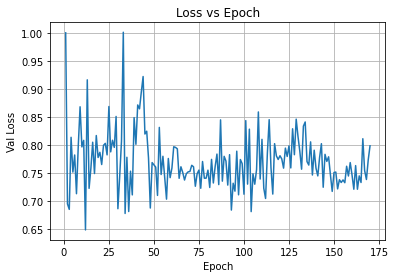

In [ ]:
plt.plot(range(1,171),val_loss)
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.title('Loss vs Epoch')
plt.grid()

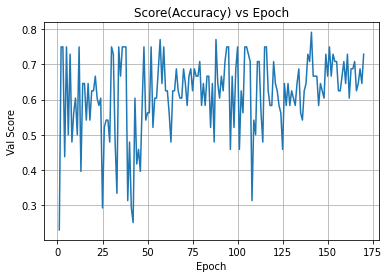

In [ ]:
plt.plot(range(1,171),val_score)
plt.xlabel('Epoch')
plt.ylabel('Val Score')
plt.title('Score(Accuracy) vs Epoch')
plt.grid()

In [ ]:
torch.save(model.state_dict(), './model_emotion.pth')

In [ ]:
model.load_state_dict(torch.load('./model_emotion.pth', map_location=device), strict=False)